In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1. Loading Libraries

In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter
from itertools import cycle                   
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
tqdm.pandas()

from autocorrect import Speller
from textblob import TextBlob
from imblearn.under_sampling import RandomUnderSampler

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/tripadvisor_hotel_reviews.csv', engine='python', encoding='utf-8')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# 3. Initial Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


Text(0.5, 1.0, 'Rating Distribution Across Dataset')

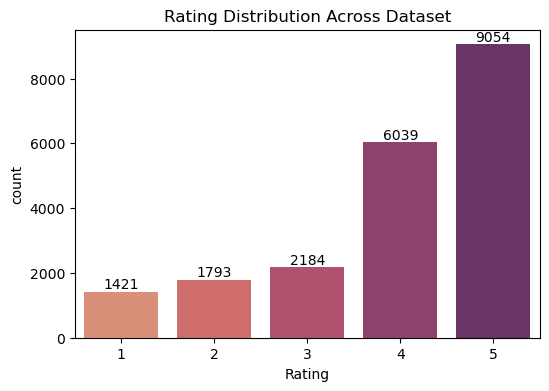

In [5]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'Rating', palette='flare')
ax.bar_label(ax.containers[0])
ax.set_title('Rating Distribution Across Dataset')

# 4. Preprocessing Text

### 4.1. Labeling

In [6]:
data['label'] = data['Rating'].map({1 : 0, 
                                    2 : 0, 
                                    3 : 1, 
                                    4 : 2, 
                                    5 : 2})
data.head()

,Review,Rating,label
0,nice hotel expensive parking got good deal sta...,4,2
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,1
3,"unique, great stay, wonderful time hotel monac...",5,2
4,"great stay great stay, went seahawk game aweso...",5,2


### 4.4. Cleaning combined_text Column

In [7]:
[word for word in data['Review']]

['nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  ',
 'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom un

In [8]:
def lower_text(text):
    return text.lower()

def clean_text(text):
    text = re.sub("[^a-z0-9\s]","", text)
    return text

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def lemmatizer(text):
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ''.join(sentence)

stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

In [9]:
data['clean_text'] = data['Review'] \
                    .progress_apply(lower_text) \
                    .progress_apply(lambda x: ' '.join([word for word in x.split() if word not in (nltk_stopword)])) \
                    .progress_apply(clean_text) \
                    .progress_apply(lemmatizer) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split() if len(word) >= 4]))
                    # .progress_apply(remove_duplicate_words) \

data.head()

  0%|          | 0/20491 [00:00<?, ?it/s]

  0%|          | 0/20491 [00:00<?, ?it/s]

  0%|          | 0/20491 [00:00<?, ?it/s]

  0%|          | 0/20491 [00:00<?, ?it/s]

,Review,Rating,label,clean_text
0,nice hotel expensive parking got good deal sta...,4,2,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,0,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,1,nice rooms 4 experience hotel monaco seattle g...
3,"unique, great stay, wonderful time hotel monac...",5,2,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,2,great stay great stay went seahawk game awesom...


In [15]:
# np.savetxt(r'clean_text_typo_stopword.csv', data.values, fmt='%s')

In [10]:
[word for word in data['clean_text']]

['nice hotel expensive parking got good deal stay hotel anniversary arrived late evening took advice previous reviews valet parking check quick easy little disappointed nonexistent view room room clean nice size bed comfortable woke stiff neck high pillows soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway maybe noisy neighbors aveda bath products nice goldfish stay nice touch taken advantage staying longer location great walking distance shopping overall nice experience pay 40 parking night',
 'ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle start booked suite paid extra website description not suite bedroom bathroom standard hotel room took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast got kidding embassy suits sitting room bathroom bedroom unlike kimpton calls suite 5 day stay offer corre

### 4.5. Reduce the sentence to be processed according to the desired number of words

<Axes: xlabel='text_len'>

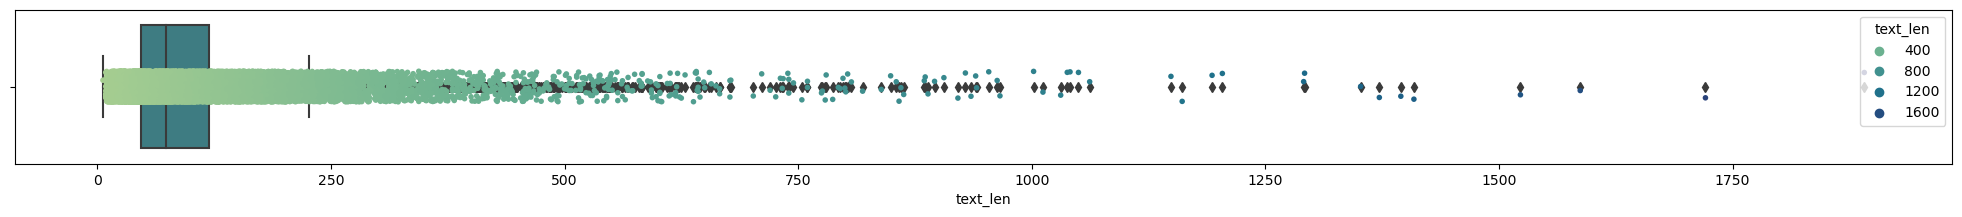

In [11]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

sns.stripplot(x=data['text_len'], data=data,
              size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

In [13]:
print(data['text_len'].quantile(0.1))
print(data['text_len'].quantile(0.95))

31.0
264.0


31.0
264.0


<Axes: xlabel='text_len'>

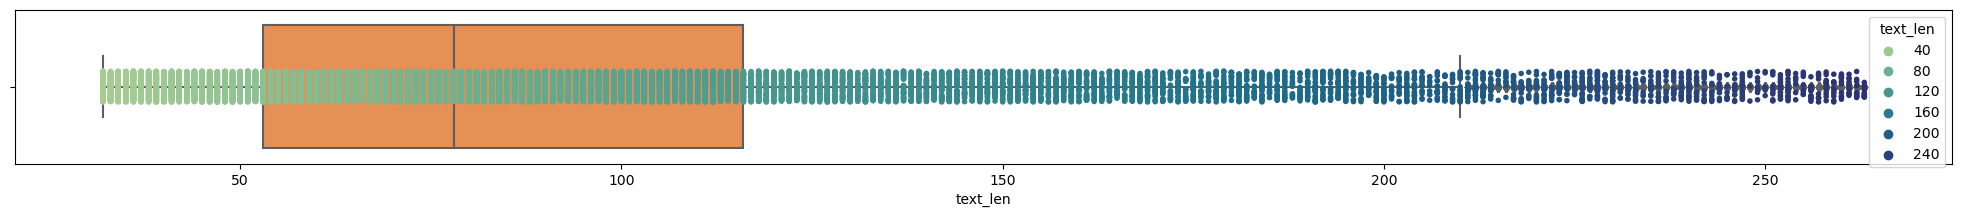

In [14]:
Q1 = data['text_len'].quantile(0.1)
Q3 = data['text_len'].quantile(0.95)

print(Q1)
print(Q3)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="Oranges")

sns.stripplot(x=data['text_len'], data=data,
              size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 4.6. Visualize # of label after preprocessing

[Text(0, 0, '2774'), Text(0, 0, '1860'), Text(0, 0, '12693')]

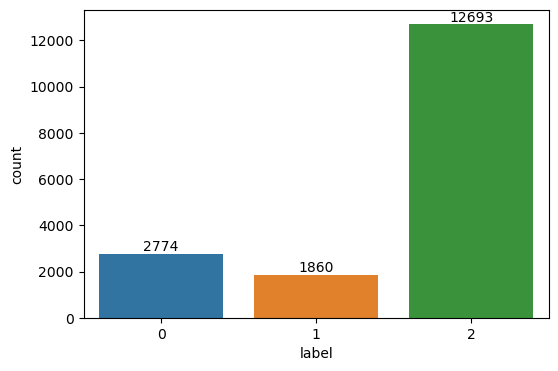

In [15]:
plt.subplots(figsize = (6,4))
ax = sns.countplot(data = data, x = 'label')
ax.bar_label(ax.containers[0])

# 5. Model

### 5.1. Splitting data into Training, Testing, and Validating data

In [16]:
X = data['clean_text']
Y = to_categorical(data['label'])

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12163,)
(3431,)
(1733,)


### 5.2. Declare parameter for Tokenizing and Training Model process

In [17]:
vocab_size = 10000
embedding_dim = 256
max_length = 265
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

### 5.3. Tokenizing text

In [30]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

67450


In [21]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

# training_label = to_categorical(training_label)
# testing_label = to_categorical(testing_label)
# validating_label = to_categorical(validating_label)

print(len(training_label))
print(len(testing_label))
print(len(validating_label))


67450
3993
1095
492


### 5.4. Build Deep Learning Models

In [24]:
def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.8))
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    # model.add(Conv1D(32, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    # model.add(Conv1D(32, 3, kernel_regularizer=keras.regularizers.l2(l=0.01)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(2048, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(32, activation='swish'))
    model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    # model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(256, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    return model
    

# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.00001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 265, 256)          2560000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,889,731
Trainable params: 2,889,731
Non-trainable params: 0
_________________________________________________________________


### 5.5. Training the Model

In [25]:
num_epoch = 50
batch_size = 64

history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (testing_padded, testing_label))

Epoch 1/50
63/63 [==============================] - 7s 70ms/step - loss: 1.0980 - accuracy: 0.3521 - val_loss: 1.0969 - val_accuracy: 0.3644
Epoch 2/50
63/63 [==============================] - 4s 70ms/step - loss: 1.0960 - accuracy: 0.4155 - val_loss: 1.0954 - val_accuracy: 0.4338
Epoch 3/50
63/63 [==============================] - 4s 62ms/step - loss: 1.0939 - accuracy: 0.4808 - val_loss: 1.0938 - val_accuracy: 0.4749
Epoch 4/50
63/63 [==============================] - 4s 66ms/step - loss: 1.0917 - accuracy: 0.5089 - val_loss: 1.0921 - val_accuracy: 0.4904
Epoch 5/50
63/63 [==============================] - 4s 63ms/step - loss: 1.0894 - accuracy: 0.5287 - val_loss: 1.0903 - val_accuracy: 0.4986
Epoch 6/50
63/63 [==============================] - 4s 64ms/step - loss: 1.0867 - accuracy: 0.5457 - val_loss: 1.0882 - val_accuracy: 0.5224
Epoch 7/50
63/63 [==============================] - 4s 66ms/step - loss: 1.0838 - accuracy: 0.5577 - val_loss: 1.0860 - val_accuracy: 0.5315
Epoch 8/50
63

# 6. Evaluating Performance

### 6.21. Plotting Accuracy and Loss of the Model

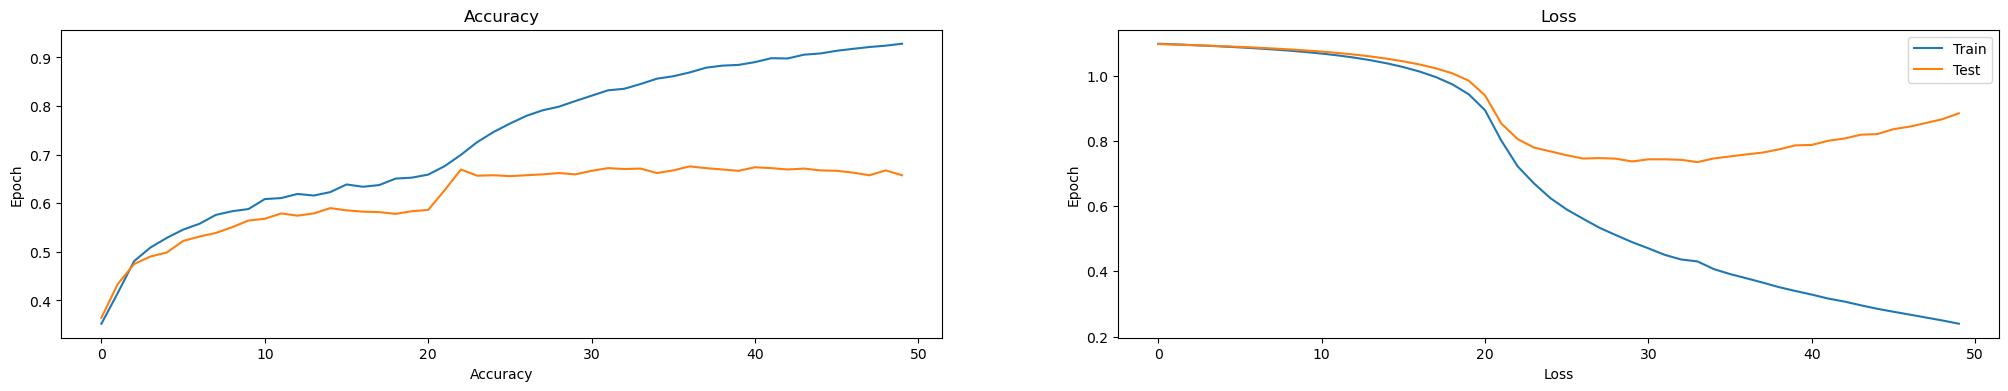

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

### 6.2. Confusion Matrix

18/18 [==============================] - 2s 59ms/step


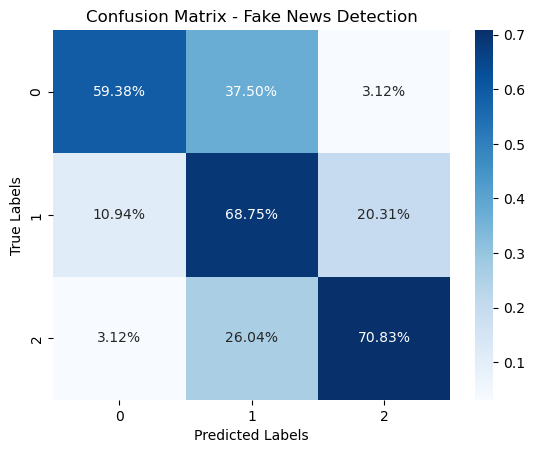

In [28]:
# labels = ['No Fraud', 'Fraud']

y_pred = np.rint(model.predict(validating_padded))
# Build confusion matrix
con_mat = confusion_matrix(validating_label.argmax(axis=1),y_pred.argmax(axis=1))

# Compute the percentages for the confusion matrix
cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

# Create the heatmap using Seaborn
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')

# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

In [23]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(validating_padded))

print(classification_report(validating_label.argmax(axis=1),y_pred.argmax(axis=1)))

18/18 [==============================] - 1s 60ms/step
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       192
           1       0.51      0.70      0.59       192
           2       0.81      0.61      0.70       192

    accuracy                           0.65       576
   macro avg       0.68      0.65      0.65       576
weighted avg       0.68      0.65      0.65       576



### 6.3. ROC Curve 

18/18 [==============================] - 1s 58ms/step


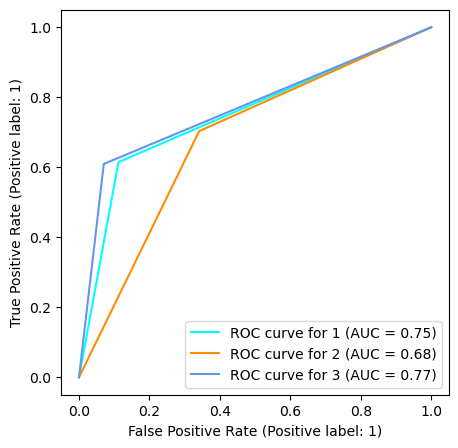

In [24]:
y_pred = np.rint(model.predict(validating_padded))
n_classes = 3

fig, ax = plt.subplots(figsize=(5, 5))
# target_names = ['1', '2', '3', '4', '5']
target_names = ['1', '2', '3']

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        validating_label[:, class_id],
        y_pred[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )